In [ ]:
import tensorflow as tf
from keras.layers import *
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential

In [ ]:
def get_encoder(input_shape=(128,128,1), output_shape=16, activation='relu'):
    model = Sequential()
    model.add(Conv2D(64, 5, activation=activation, input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, 5, activation=activation))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(16, 3, activation=activation))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(4, 3, activation=activation))
    model.add(Flatten())
    model.add(Dense(output_shape, activation='softmax'))

    return model

In [ ]:
def get_middle_model(input_shape=3*16, activation='softmax'):
    model = Sequential()
    model.add(Dense(input_shape, input_dim=input_shape, activation=activation))
    model.add(Dense(12, activation=activation))
    model.add(Dense(12, activation=activation))
    model.add(Dense(input_shape, activation=activation))

    return model

In [ ]:
def get_decoder(input_shape=16, activation='relu'):
    model = Sequential()
    model.add(Dense(input_shape, input_dim=input_shape, activation=activation))
    model.add(Reshape((4, 4, 1)))
    model.add(Conv2DTranspose(64,(3, 3), strides=2, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2DTranspose(64,(3, 3), strides=4, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2DTranspose(32,(3, 3), strides=4, activation='relu', padding='same'))
    model.add(Conv2D(1, (2, 2), activation='sigmoid', padding='same'))

    return model

In [ ]:
class Generator(tf.keras.Model):
  def __init__(self):
    super().__init__()
    self.encoder1 = tf.keras.models.clone_model(get_encoder(output_shape=16))
    self.encoder2 = tf.keras.models.clone_model(get_encoder(output_shape=16))
    self.encoder3 = tf.keras.models.clone_model(get_encoder(output_shape=16))

    self.middle_model = tf.keras.models.clone_model(get_middle_model())

    self.decoder1 = tf.keras.models.clone_model(get_decoder())
    self.decoder2 = tf.keras.models.clone_model(get_decoder())
    self.decoder3 = tf.keras.models.clone_model(get_decoder())

  def call(self, inputs):
    assert len(inputs) == 3

    out1 = self.encoder1(inputs[0])
    out2 = self.encoder2(inputs[1])
    out3 = self.encoder3(inputs[2])

    self.out = np.concatenate((out1[0], out2[0], out3[0]), axis = 0)
    self.out = self.middle_model(self.out.reshape(1, self.out.shape[0]))

    out1 = self.decoder1(tf.reshape(self.out[0][:16], shape=(1, 16)))
    out2 = self.decoder1(tf.reshape(self.out[0][16:32], shape=(1, 16)))
    out3 = self.decoder1(tf.reshape(self.out[0][32:], shape=(1, 16)))

    return [out1, out2, out3] 

In [ ]:
class Discriminator(tf.keras.Model):
  def __init__(self):
    super().__init__()
    self.encoder1 = tf.keras.models.clone_model(get_encoder(output_shape=1))
    self.encoder2 = tf.keras.models.clone_model(get_encoder(output_shape=1))

  def call(self, inputs):
    out1 = self.encoder1(inputs[0])
    out2 = self.encoder2(inputs[1])

    return [out1, out2]

In [ ]:
gen = Generator()
disc1 = Discriminator()
disc2 = Discriminator()
disc3 = Discriminator()

# single training loop
input1 = np.random.randint(255, size=(1, 128, 128, 1))
input2 = np.random.randint(255, size=(1, 128, 128, 1))
input3 = np.random.randint(255, size=(1, 128, 128, 1))

input = [input1, input2, input3]
output = gen([input1, input2, input3])

d_out1 = disc1([input[0], output[0]])
d_out2 = disc2([input[1], output[1]])
d_out3 = disc3([input[2], output[2]])

print("discriminator outputs")
print("d_out1", d_out1[0].numpy()[0][0], d_out1[1].numpy()[0][0])
print("d_out2", d_out2[0].numpy()[0][0], d_out2[1].numpy()[0][0])
print("d_out3", d_out3[0].numpy()[0][0], d_out3[1].numpy()[0][0])

discriminator outputs
d_out1 1.0 1.0
d_out2 1.0 1.0
d_out3 1.0 1.0


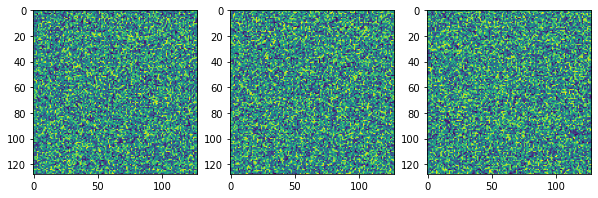

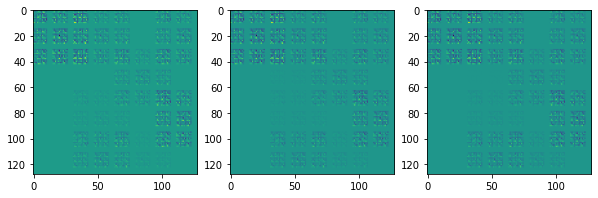

In [ ]:
# input images from generator
fig = plt.figure(figsize=(10,50))
ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(tf.reshape(input1, shape=(128, 128)))
ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(tf.reshape(input2, shape=(128, 128)))
ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(tf.reshape(input3, shape=(128, 128)))

# output images generator
fig = plt.figure(figsize=(10,50))
ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(tf.reshape(output[0], shape=(128, 128)))
ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(tf.reshape(output[1], shape=(128, 128)))
ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(tf.reshape(output[2], shape=(128, 128)))

In [ ]:
# Network Params
image_dim = 784 # 28*28 pixels * 1 channel
gen_hidden_dim = 256
disc_hidden_dim = 256
noise_dim = 200 # Noise data points

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

In [ ]:
for i in range(n_steps):
    X_real, y_real = generate_real_samples(X_train, n_batch)
    d_loss_r, d_acc_r = d_model.train_on_batch(X_real, y_real)

    X_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_batch)
    d_loss_f, d_acc_f = d_model.train_on_batch(X_fake, y_fake)
    
    z_input = generate_latent_points(latent_dim, n_batch) 
    y_gan = ones((n_batch, 1)) 
    g_loss, g_acc = gan_model.train_on_batch(z_input, y_gan)
    print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_loss_r,d_acc_r, d_loss_f,d_acc_f, g_loss,g_acc))
    if (i+1) % (bat_per_epo * 1) == 0:
        summarize_performance(i, g_model, latent_dim)

In [ ]:
batch_size = 100
rand_dim = 20
img_height = 128
img_width = 128
img_channels = 3


In [ ]:
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term
